In [1]:
import pandas as pd
import numpy as np


from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.inspection import permutation_importance

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.5)

In [2]:
df_eng = pd.read_csv('./data/takehome_user_engagement.csv')
df_users = pd.read_csv('./data/takehome_users.csv', encoding='Latin-1')

In [3]:
df_users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [4]:
df_eng

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [5]:
df_eng.time_stamp = df_eng.time_stamp.astype('datetime64')
df_eng.set_index('time_stamp', inplace = True)

In [6]:
logins_by_week = df_eng.groupby([pd.Grouper(freq='W'), 'user_id']).visited.sum().unstack(-1).copy()
logins_by_week = logins_by_week.loc[:, (logins_by_week >= 3).any()]

In [7]:
adopted_users = logins_by_week.columns

In [8]:
df_users['adopted'] = 0
df_users.loc[df_users.object_id.isin(adopted_users), 'adopted'] = 1

In [9]:
df_users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0


In [10]:
irrelevant = ['object_id','creation_time', 'name', 'email', 'last_session_creation_time','invited_by_user_id']
df_users.drop(columns=irrelevant, inplace=True)

In [11]:
one_hot_creation = pd.get_dummies(df_users.creation_source, drop_first=False,prefix='source', dtype=int)
df_users = pd.concat([one_hot_creation,df_users], axis=1)
df_users.drop(columns=['creation_source'], inplace=True)

In [12]:
one_hot_org = pd.get_dummies(df_users.org_id, drop_first=False,prefix='org', dtype=int)
df_users = pd.concat([one_hot_org,df_users], axis=1)
df_users.drop(columns=['org_id'], inplace=True)

In [13]:
# Since the target classes are unbalanced, I will undersample the dataset to get an equal amount of adopted/nonadopted users
undersampled_df = pd.concat([df_users.loc[df_users.adopted == 1], df_users.loc[df_users.adopted == 0].sample(1500)], ignore_index=True)

In [14]:
undersampled_df

,org_0,org_1,org_2,org_3,org_4,org_5,org_6,org_7,org_8,org_9,...,org_415,org_416,source_GUEST_INVITE,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
2942,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2943,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [15]:
def typical_split(X, y):
    return train_test_split(X, y, train_size=.75, random_state=47)

In [16]:
X = undersampled_df.drop(columns='adopted')
y = undersampled_df.adopted

X_train, X_test, y_train, y_test = typical_split(X, y)

In [17]:
def SVC_creator(X_train, y_train):
    losses = ['hinge', 'squared_hinge']
    duals = [True,False]
    learning_rates = list(np.logspace(-3,2,6))
    penalties = ['l1','l2']
    max_iters = [1000, 5000, 10000, 20000, 50000, 150000]

    random_grid = {
        'C': learning_rates,
        'penalty': penalties,
        'max_iter': max_iters,
        'loss': losses,
        'dual': duals
    }

    SVC = LinearSVC()
    SVC_search = RandomizedSearchCV(estimator=SVC, param_distributions=random_grid, n_iter=100, cv=10, scoring = 'roc_auc', n_jobs=-1,random_state=47)
    results = SVC_search.fit(X_train, y_train)
    
    svc = LinearSVC(penalty = results.best_params_['penalty'], 
                max_iter = results.best_params_['max_iter'], 
                loss = results.best_params_['loss'], 
                dual = results.best_params_['dual'], 
                C = results.best_params_['C'])
    return svc

In [18]:
def RF_creator(X_train, y_train):
    RF_model = RandomForestClassifier()
    grid = {
        'bootstrap': [True,False],
        'max_depth': [int(x) for x in np.linspace(50, 110,11)] + [None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [int(x) for x in np.linspace(200, 2000,10)]
    }
    search = RandomizedSearchCV(RF_model, grid, n_iter=10, scoring='roc_auc', cv=3, n_jobs=-1,random_state=47)
    results = search.fit(X_train, y_train) 

    RF_model = RandomForestClassifier(n_estimators = results.best_params_['n_estimators'], 
                                      min_samples_split = results.best_params_['min_samples_split'], 
                                      min_samples_leaf = results.best_params_['min_samples_leaf'], 
                                      max_features = results.best_params_['max_features'], 
                                      max_depth = results.best_params_['max_depth'], 
                                      bootstrap = results.best_params_['bootstrap'])
    RF_model.fit(X_train, y_train)
    
    return RF_model

In [19]:
def get_accuracy(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    print('Accuracy:',accuracy_score(y_test, y_pred))

In [20]:
def make_ROC(model, test,title):
    
    proba = model.predict_proba(X_test)[:,1]
    
    score = round(roc_auc_score(test,proba),3)
    
    fpr, tpr, thresh = roc_curve(test, proba)
    
    plt.figure(figsize=(10,8))

    line_45 = np.linspace(0, 1.0, 20)
    plt.plot(line_45, line_45, color='blue')

    plt.plot(fpr, tpr, color='red')

    plt.legend(['Baseline',title + ' AUC = ' + str(score)],loc='best')
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.title('ROC CURVE for ' + title);

In [21]:
svc = SVC_creator(X_train, y_train)

In [22]:
clf = CalibratedClassifierCV(svc,cv=5)
clf.fit(X_train, y_train)
get_accuracy(clf)

              precision    recall  f1-score   support

           0       0.56      0.61      0.58       368
           1       0.57      0.52      0.54       369

    accuracy                           0.56       737
   macro avg       0.56      0.56      0.56       737
weighted avg       0.56      0.56      0.56       737

Accuracy: 0.5630936227951153


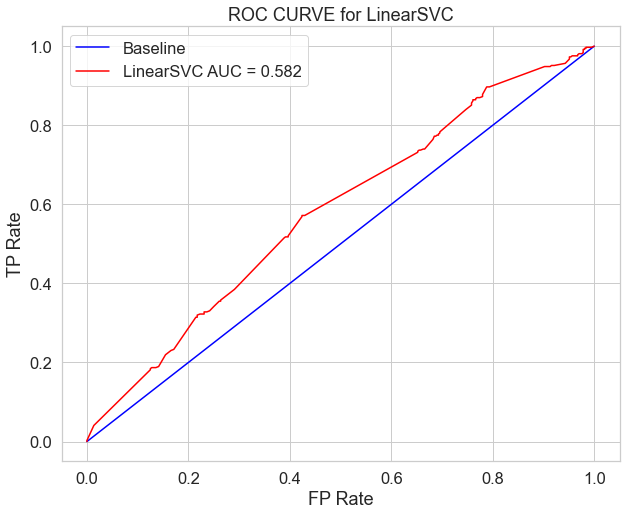

In [23]:
make_ROC(clf,y_test,"LinearSVC")

## Random Forest

In [24]:
RF_model = RF_creator(X_train, y_train)

In [25]:
get_accuracy(RF_model)

              precision    recall  f1-score   support

           0       0.56      0.64      0.60       368
           1       0.58      0.50      0.54       369

    accuracy                           0.57       737
   macro avg       0.57      0.57      0.57       737
weighted avg       0.57      0.57      0.57       737

Accuracy: 0.5685210312075983


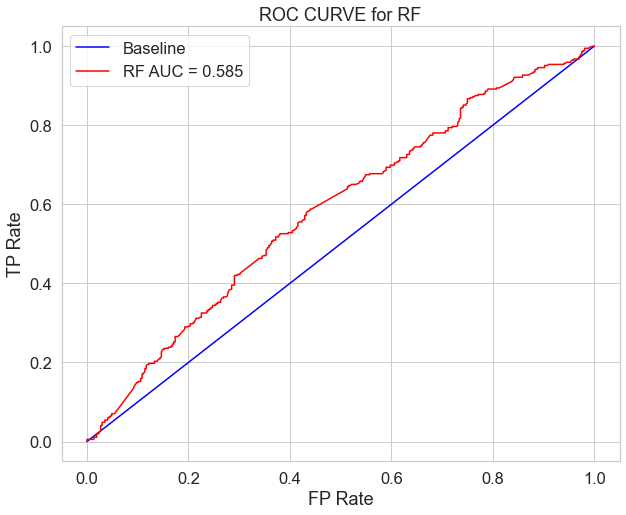

In [26]:
make_ROC(RF_model,y_test,"RF")

In [27]:
perm_importance = permutation_importance(RF_model, X_test, y_test,n_jobs=-1,scoring = 'roc_auc',n_repeats=10)
sorted_idx = perm_importance.importances_mean.argsort()
top_RF = X_test.columns[sorted_idx][-10:]
top_RF

Index(['org_1', 'org_4', 'org_6', 'org_13', 'org_0', 'org_3',
       'source_SIGNUP_GOOGLE_AUTH', 'source_ORG_INVITE', 'source_GUEST_INVITE',
       'source_PERSONAL_PROJECTS'],
      dtype='object')

In [28]:
perm_importance = permutation_importance(clf, X_test, y_test,n_jobs=-1,scoring = 'roc_auc',n_repeats=20)
sorted_idx = perm_importance.importances_mean.argsort()
top_SVC = X_test.columns[sorted_idx][-10:]
top_SVC

Index(['source_SIGNUP', 'org_3', 'org_6', 'opted_in_to_mailing_list', 'org_4',
       'source_ORG_INVITE', 'org_0', 'source_SIGNUP_GOOGLE_AUTH',
       'source_GUEST_INVITE', 'source_PERSONAL_PROJECTS'],
      dtype='object')

In [29]:
combined_feats = list(set(top_RF) | set(top_SVC))
combined_feats

['org_0',
 'source_SIGNUP_GOOGLE_AUTH',
 'opted_in_to_mailing_list',
 'org_3',
 'org_1',
 'org_4',
 'source_PERSONAL_PROJECTS',
 'org_13',
 'source_GUEST_INVITE',
 'org_6',
 'source_SIGNUP',
 'source_ORG_INVITE']

### Let's see how our models behave if we only use the most important features for training/testing

In [30]:
X = undersampled_df.drop(columns='adopted')[combined_feats]

X_train, X_test, y_train, y_test = typical_split(X,y)

## SVC

In [31]:
svc = SVC_creator(X_train, y_train)

In [32]:
clf = CalibratedClassifierCV(svc,cv=5)
clf.fit(X_train, y_train)
get_accuracy(clf)

              precision    recall  f1-score   support

           0       0.57      0.64      0.60       368
           1       0.59      0.51      0.55       369

    accuracy                           0.58       737
   macro avg       0.58      0.58      0.58       737
weighted avg       0.58      0.58      0.58       737

Accuracy: 0.5780189959294437


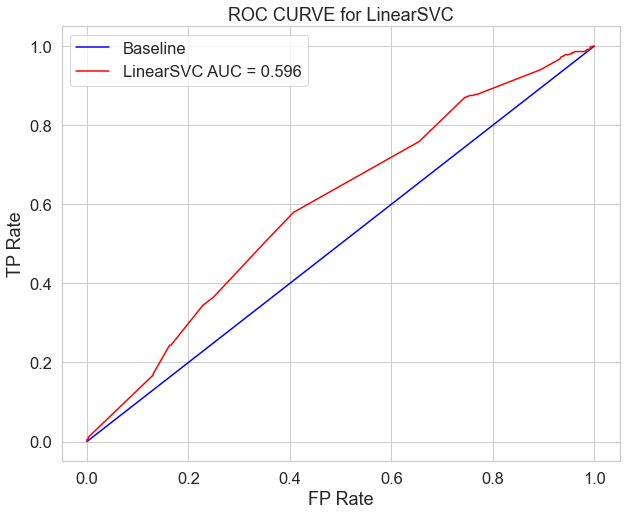

In [33]:
make_ROC(clf,y_test,"LinearSVC")

## Random Forest

In [34]:
RF_model = RF_creator(X_train, y_train)

In [35]:
get_accuracy(RF_model)

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       368
           1       0.58      0.59      0.58       369

    accuracy                           0.58       737
   macro avg       0.58      0.58      0.58       737
weighted avg       0.58      0.58      0.58       737

Accuracy: 0.582089552238806


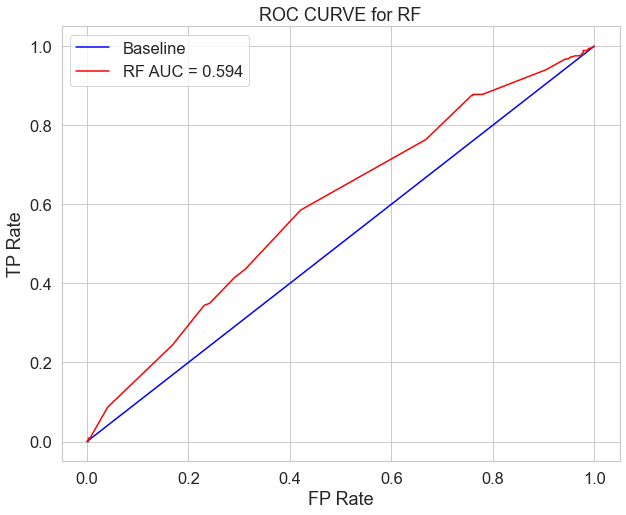

In [36]:
make_ROC(RF_model,y_test,"RF")

In [37]:
combined_feats

['org_0',
 'source_SIGNUP_GOOGLE_AUTH',
 'opted_in_to_mailing_list',
 'org_3',
 'org_1',
 'org_4',
 'source_PERSONAL_PROJECTS',
 'org_13',
 'source_GUEST_INVITE',
 'org_6',
 'source_SIGNUP',
 'source_ORG_INVITE']

The ROC/AUC score is nearly the same for LinearSVC and the RF model, using only a few features

### Summary/Findings

The steps I used to find the most important features:

1. Train two models using ALL of the relevant features
2. Note down the accuracy and ROC/AUC score
3. Run Permutation importance on the test set to extract the most important features from both models
4. Concatenate the list of features 
5. Use only these features to train the two models
6. See if the accuracy and ROC/AUC score has had any significant change

Using these steps I was able to cut down on the the amount of features from 424 to around 10-15 depending on the run while maintaining very similar accuracy and ROC/AUC scores. The features that seemed to stay run after run of these steps, were:

<li> source_PERSONAL_PROJECTS
<li> source_SIGNUP
<li> source_GUEST_INVITE
<li> source_ORG_INVITE
<li> org_0
<li> org_1